# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
from sparse_field_lib import load_data

In [3]:
import matplotlib.pyplot as plt
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [4]:
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [5]:
device = torch.device('cuda:0')

In [6]:
!echo $CUDA_VISIBLE_DEVICES

7


# Load data

In [7]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [8]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [9]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)

## Look at complete image

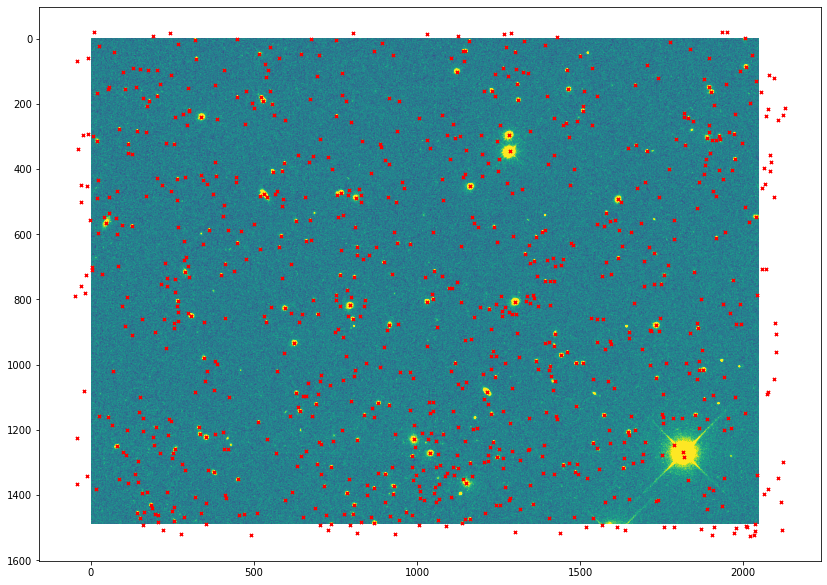

In [11]:
%matplotlib inline
plt.figure(figsize=(14,14))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(pt, pr, marker='x', color='r', s=10)


## choose one chunk

In [12]:
# prepare chunk
# i, j = np.random.randint(0, 6, size=(2))
# i,j = (1,5)
clen = 200
xlim = (450, 650)
ylim = (350, 550)
print(xlim, ylim)

chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

# restrict to 200x200 chunk 
keep = (pt > xlim[0]) & (pt < xlim[1]) & (pr < ylim[1]) & (pr > ylim[0])
keep_frame = (pt_frame > xlim[0]) & (pt_frame < xlim[1]) & (pr_frame < ylim[1]) & (pr_frame > ylim[0])

# obtain star and galaxy bools for each location.
is_star = fits_file['probpsf'][:].astype(bool)
is_star_frame = (frame_fits['OBJC_TYPE'][:]==6).astype(bool)
galaxy_bool = (~is_star) & keep
star_bool = is_star & keep
galaxy_bool_frame = (~is_star_frame) & keep_frame
star_bool_frame = (is_star_frame) & keep_frame

#account for bias
_pt = pt - xlim[0]
_pr = pr - ylim[0]

_pt_frame = pt_frame - xlim[0]
_pr_frame = pr_frame - ylim[0]

(450, 650) (350, 550)


In [14]:
# move image to device
slen = 200
chunks = chunk.reshape(1, 1, *chunk.shape)[:, :, :slen, :slen].to(device)

## get estimate from chunk

In [15]:
# read sleep 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
image_encoder = image_encoder.eval()

In [16]:
with torch.no_grad():

    tile_est = sleep_net.tile_images_map_estimate(chunks)
    sleep_net.image_decoder.background_values = (633.0, )
    
    # plot image from tile est.
    recon_image, _ = sleep_net.image_decoder.render_images(
        tile_est["n_sources"],
        tile_est["locs"],
        tile_est["galaxy_bool"],
        tile_est["galaxy_params"],
        tile_est["fluxes"],
        add_noise=False,
    )
    
    _slen = chunks.shape[-1] - image_encoder.border_padding*2
    est_params = encoder.get_full_params(tile_est, _slen)

In [19]:
import plotly.express as px
import plotly.graph_objects as go

# figure out colorbar and image ranges. 
p_level = 0.05
vmin = np.percentile(chunk.flatten(), p_level)
vmax = np.percentile(chunk.flatten(), 100-p_level)
fig = px.imshow(chunk, zmin=vmin, zmax=vmax)



# scatter objects.

scatter_galaxies_frame = go.Scatter(name='frame_galaxy', x=_pt_frame[galaxy_bool_frame], y=_pr_frame[galaxy_bool_frame], mode='markers', marker=dict(color='green', size=8, symbol='x'))
scatter_stars_frame = go.Scatter(name='frame_star', x=_pt_frame[star_bool_frame], y=_pr_frame[star_bool_frame], mode='markers', marker=dict(color='purple', size=8, symbol='x'))

scatter_galaxies_true = go.Scatter(name='true_galaxy', x=_pt[galaxy_bool], y=_pr[galaxy_bool], mode='markers', marker=dict(color='red', size=8, symbol='x'))
scatter_stars_true = go.Scatter(name='true_star', x=_pt[star_bool], y=_pr[star_bool], mode='markers', marker=dict(color='orange', size=8, symbol='x'))

_locs = est_params['locs']*_slen + image_encoder.border_padding
_locs = _locs.detach().cpu().numpy()[0]
_galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
_prob_galaxy = est_params['prob_galaxy'].float().detach().cpu().numpy()[0, :, 0]
_prob_n_sources = est_params['prob_n_sources'].float().detach().cpu().numpy()[0, :, 1]


scatter_galaxies_est = go.Scatter(name='est_galaxy', x=_locs[:, 1][_galaxy_bool], y=_locs[:, 0][_galaxy_bool], 
                                  mode='markers', marker=dict(color='blue', size=8, symbol='cross'),
                                  hovertext=[f'prob_galaxy:{x:.2f}; prob_one_source: {y:.2f}' for (x,y) 
                                             in zip(_prob_galaxy[_galaxy_bool], _prob_n_sources[_galaxy_bool])]
                                 )
scatter_stars_est = go.Scatter(name='est_star', x=_locs[:, 1][~_galaxy_bool], y=_locs[:, 0][~_galaxy_bool], 
                               mode='markers', marker=dict(color='cyan', size=8, symbol='cross'),
                              hovertext=[f'prob_galaxy:{x:.2f}; prob_one_source: {y:.2f}' for (x,y) in 
                                         zip(_prob_galaxy[~_galaxy_bool], _prob_n_sources[~_galaxy_bool])]
                              )

# add traces
fig.update_layout(width=800, height=800)
fig.add_trace(scatter_galaxies_true)
fig.add_trace(scatter_stars_true)
fig.add_trace(scatter_galaxies_est)
fig.add_trace(scatter_stars_est)
fig.add_trace(scatter_galaxies_frame)
fig.add_trace(scatter_stars_frame)

fig.update_layout(legend=dict(orientation="h", y=1.02))

fig.show()


red = galaxy
blue = star


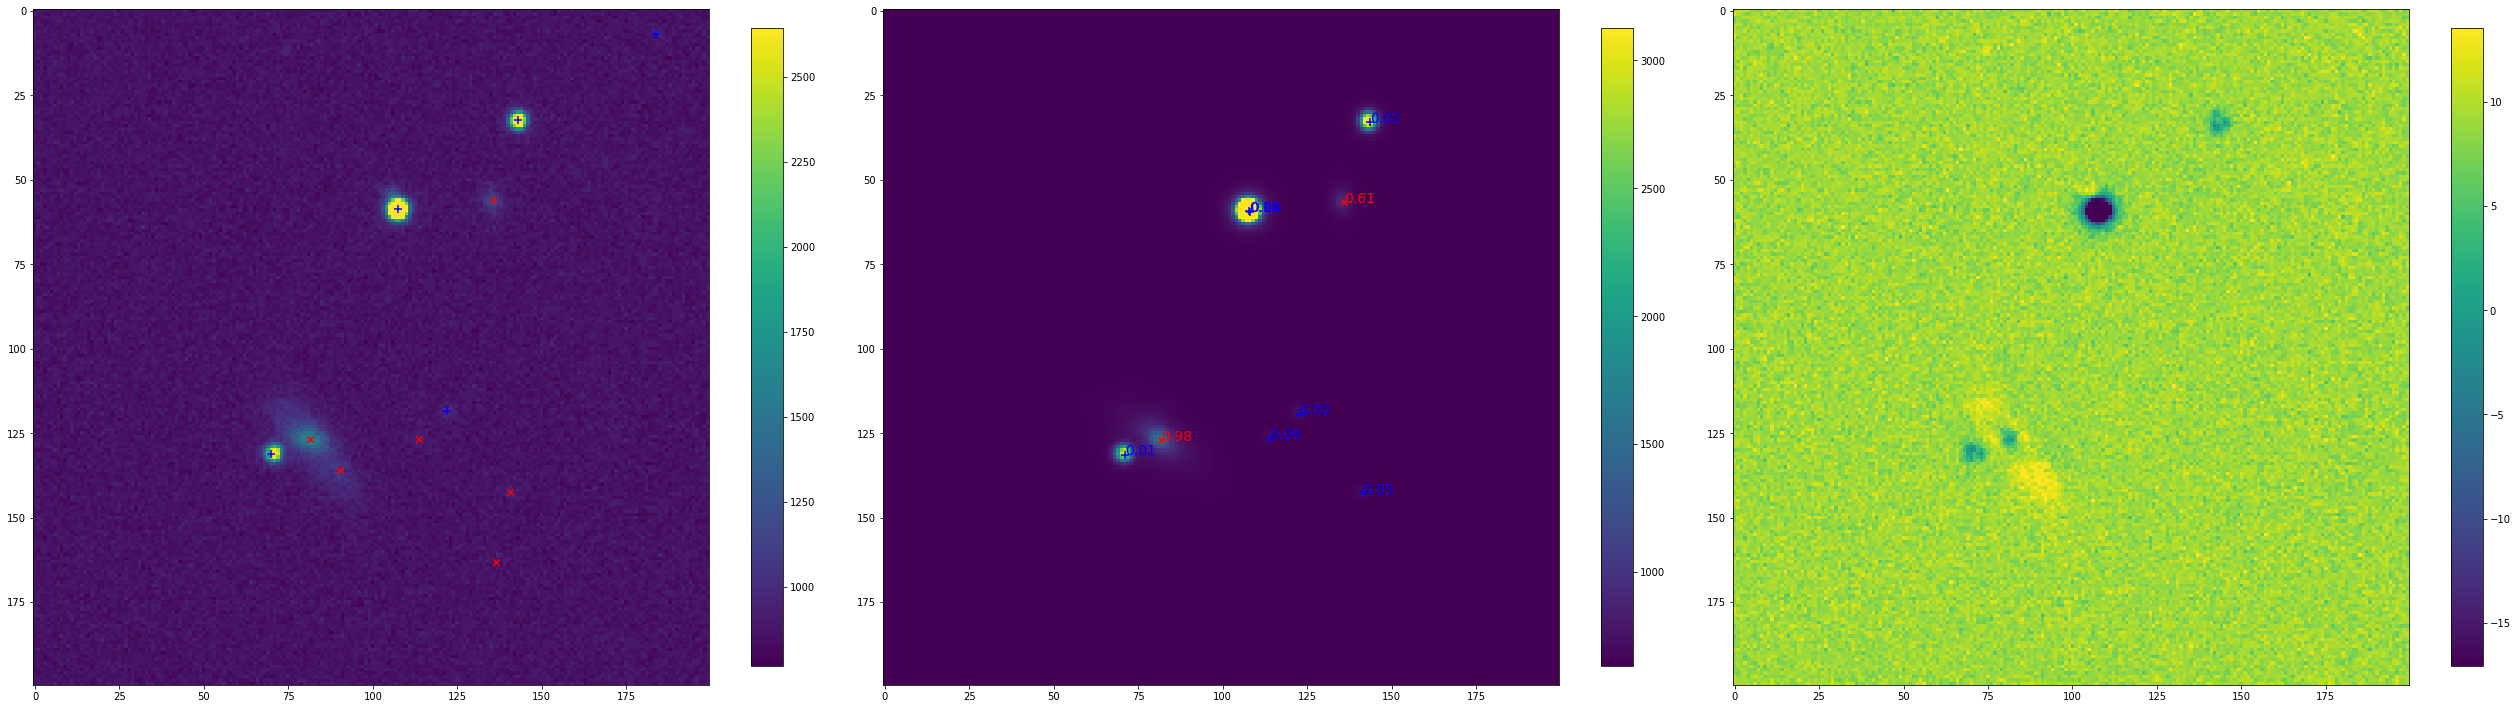

In [20]:
%matplotlib inline
# plot both images side by side.
fig, axes = plt.subplots(1, 3, figsize=(36,18))
_recon_image = recon_image.detach().cpu().numpy()[0, 0]
residual = (chunk - _recon_image)/np.sqrt(_recon_image)

ax1, ax2, ax3 = axes


p = 0.1
combined = np.hstack([chunk.flatten(), _recon_image.flatten()])
vmin = np.percentile(combined, p)
vmax = np.percentile(combined, 100-p)

# plot the chunk and reconstruction image side by side.
im1 = ax1.imshow(chunk, vmin=np.percentile(chunk.flatten(), p), vmax=np.percentile(chunk.flatten(), 100-p))
im2 = ax2.imshow(_recon_image, vmin=np.percentile(_recon_image.flatten(), p), vmax=np.percentile(_recon_image.flatten(), 100-p))
im3 = ax3.imshow(residual, vmin=np.percentile(residual.flatten(), p), vmax=np.percentile(residual.flatten(), 100-p))

# true image and true locations
ax1.scatter(_pt[galaxy_bool], _pr[galaxy_bool], marker='x', color='r', s=40)
ax1.scatter(_pt[star_bool], _pr[star_bool], marker='+', color='b', s=50)

# # frame
# ax1.scatter(_pt_frame[galaxy_bool_frame], _pr_frame[galaxy_bool_frame], marker='x', color='r', s=40)
# ax1.scatter(_pt_frame[star_bool_frame], _pr_frame[star_bool_frame], marker='+', color='b', s=50)


# overlay the map estimate params on the full image
_locs = est_params['locs']*_slen + image_encoder.border_padding
_locs = _locs.detach().cpu().numpy()[0]
_galaxy_bool = est_params['galaxy_bool'].bool().detach().cpu().numpy()[0, :, 0]
ax2.scatter(_locs[:, 1][_galaxy_bool], _locs[:, 0][_galaxy_bool], marker='x', color='r', s=40)
ax2.scatter(_locs[:, 1][~_galaxy_bool], _locs[:, 0][~_galaxy_bool], marker='+', color='b', s=50)

# annotate with probabilities for sharing
for prob, (yi, xi) in zip(_prob_galaxy[_galaxy_bool], _locs[_galaxy_bool]):
    ax2.annotate(f"{prob:.2f}", (xi, yi), color='r', fontsize=14)

for prob, (yi, xi) in zip(_prob_galaxy[~_galaxy_bool], _locs[~_galaxy_bool]):
    ax2.annotate(f"{prob:.2f}", (xi, yi), color='b', fontsize=14)


# colorbar
fig.colorbar(im1, ax=ax1, shrink=0.5)
fig.colorbar(im2, ax=ax2, shrink=0.5)
fig.colorbar(im3, ax=ax3, shrink=0.5)



plt.tight_layout()

print('red = galaxy')
print('blue = star')